<a href="https://colab.research.google.com/github/kengranyiye/Recognition/blob/master/%E2%80%9Cseg_gpu_(2)_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-based Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed. If GPU is available, but you want to use CPU to train your model, make sure you add " os.environ['CUDA_VISIBLE_DEVICES'] = '-1' " before "from keras.preprocessing.image import ImageDataGenerator"

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install tensorflow


     |████████████████████████████████| 394.3MB 45kB/s 


In [ ]:
import tensorflow as tf
# tf.test.is_gpu_available()
# tf.test.gpu_device_name()
tf.config.list_physical_devices('GPU')
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
!unzip "/content/drive/MyDrive/data.zip" -d "/content/data"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/data/proj_tech/Dataset/Yes/2175_img.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2175_seg.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2178_img.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2178_seg.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2181_img.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2181_seg.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2190_img.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2190_seg.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2191_img.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2191_seg.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2192_img.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2192_seg.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2193_img.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2193_seg.npy  
  inflating: /content/data/proj_tech/Dataset/Yes/2194_img.npy  
  inflating: 

In [ ]:
%cd /content/data/proj_tech

/content/data/proj_tech


In [ ]:
import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
#uncomment if using linux/macos
!rm -rf TrainSeg ValSeg
!mkdir TrainSeg ValSeg TrainSeg/Yes ValSeg/Yes

#uncomment if using windows
#!rmdir TrainSeg ValSeg /s /q
#!md TrainSeg ValSeg TrainSeg\Yes ValSeg\Yes


img_path = 'Dataset/'
train_list = []
val_list = []
CLASS = 'Yes'
all_files = os.listdir(img_path + CLASS)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
img_num = len(files)
for (n, file_name) in enumerate(files):
    img = os.path.join(img_path,CLASS,file_name)
    seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
    # 80% of images will be used for training, change the number here 
    # to use different number of images for training your model.
    if n < 0.8*img_num:
        shutil.copy(img, os.path.join('TrainSeg/',CLASS,file_name))
        train_list.append(os.path.join('TrainSeg/',CLASS,file_name))
        shutil.copy(seg, os.path.join('TrainSeg/',CLASS,file_name.split('_')[0]+'_seg.npy'))
    else:
        shutil.copy(img, os.path.join('ValSeg/',CLASS,file_name))
        val_list.append(os.path.join('ValSeg/',CLASS,file_name))
        shutil.copy(seg, os.path.join('ValSeg/',CLASS,file_name.split('_')[0]+'_seg.npy'))

In [ ]:
print(img_num)
print(len(train_list))
print(len(val_list))

3319
2656
663


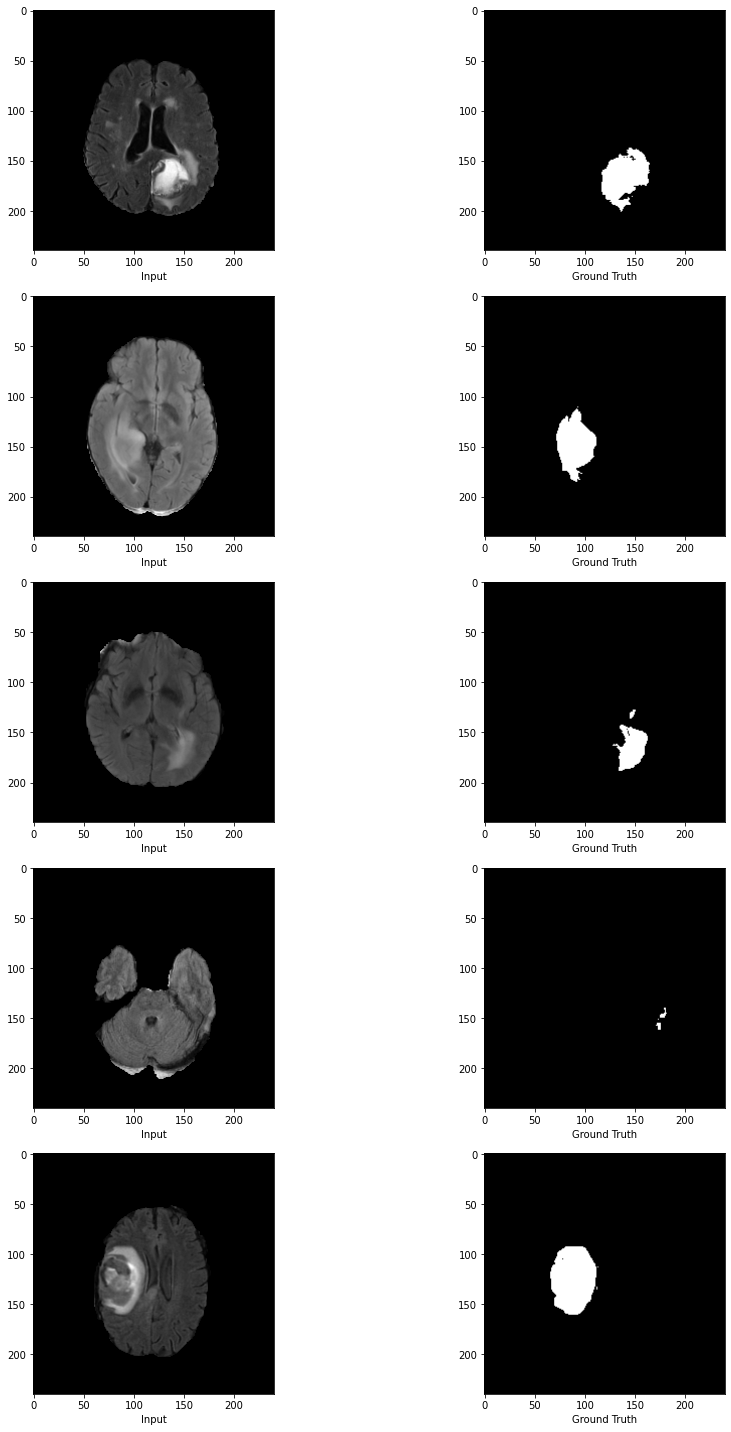

In [ ]:
def plot_samples(x,n=10):
    i = n
    j = 2
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        plt.subplot(i,j,k)
        while k%2 != 0:
            plt.imshow(np.load(x[idx])[:,:,0], cmap='gray')
            plt.xlabel("Input")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(np.load(x[idx].split('_')[0]+'_seg.npy')[:,:], cmap='gray')
        plt.xlabel("Ground Truth")
        k += 1
    plt.tight_layout()
    plt.show()

plot_samples(train_list, n=5)

In [ ]:
%cd /content/data/proj_tech

/content/data/proj_tech


In [ ]:
print(len(train_list))
print(len(val_list))
print(train_list[:4])
print(val_list[:4])

2656
663
['TrainSeg/Yes/5293_img.npy', 'TrainSeg/Yes/5199_img.npy', 'TrainSeg/Yes/5987_img.npy', 'TrainSeg/Yes/4842_img.npy']
['ValSeg/Yes/7012_img.npy', 'ValSeg/Yes/164_img.npy', 'ValSeg/Yes/7119_img.npy', 'ValSeg/Yes/1058_img.npy']


In [ ]:
import numpy as np
import os

files_list = []
for path, subdirs, all_files in os.walk("TrainSeg"):
    ''' segmentation组改成"seg" '''
    files = [item for item in all_files if "img" in item]
    for name in files:
        files_list.append(os.path.join(path, name))

for filename in files_list:
    img=np.load(filename)

    pref=filename[:filename.index("_")]
    suff=filename[filename.index("_"):]

    '''水平翻转'''
    flipped_img=np.zeros(shape=(240,240,3))
    for i in range(239):
        for j in range(239):
            for k in range(3):
                flipped_img[i][j][k]=img[239-i][j][k]
    flipped_img = np.fliplr(img)
    np.save(pref+"flipped"+suff,flipped_img)

files_list = []
for path, subdirs, all_files in os.walk("TrainSeg"):
    ''' segmentation组改成"seg" '''
    files = [item for item in all_files if "seg" in item]
    for name in files:
        files_list.append(os.path.join(path, name))

for filename in files_list:
    img=np.load(filename)

    pref=filename[:filename.index("_")]
    suff=filename[filename.index("_"):]

    '''水平翻转'''
    flipped_img=np.zeros(shape=(240,240))
    for i in range(239):
        for j in range(239):
                flipped_img[i][j]=img[239-i][j]
    flipped_img = np.fliplr(img)
    np.save(pref+"flipped"+suff,flipped_img)

KeyboardInterrupt: ignored

In [ ]:
print(len(train_list))
print(len(val_list))
print(train_list[:4])
print(val_list[:4])

5312
663
['TrainSeg/Yes/5642_img.npy', 'TrainSeg/Yes/2324_img.npy', 'TrainSeg/Yes/6369_img.npy', 'TrainSeg/Yes/6231flipped_img.npy']
['ValSeg/Yes/286_img.npy', 'ValSeg/Yes/6490_img.npy', 'ValSeg/Yes/5427_img.npy', 'ValSeg/Yes/1357_img.npy']


In [ ]:
img_path = 'TrainSeg/'
train_list = []
CLASS = 'Yes'
all_files = os.listdir(img_path + CLASS)
files = [item for item in all_files if "img" in item]
filesseg = [item for item in all_files if "seg" in item]
for (n, file_name) in enumerate(files):
    train_list.append(os.path.join('TrainSeg/',CLASS,file_name))
    
   
   

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=16, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = np.load(ID)

            # Store segmentation map
            y[i] = np.load(ID[:-8] +'_seg.npy')

        return X, y

In [ ]:
train_generator = DataGenerator(train_list)
validation_generator = DataGenerator(val_list)
IMG_SIZE = (240,240)
RANDOM_SEED = 100

In [ ]:
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
    # Drop-Based Learning Rate Decay
import math
from  tensorflow.keras.optimizers import SGD
from  tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
def unet(input_size = (240,240,3)):
    inputs = Input(input_size)
    lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
    conv1 = Conv2D(64, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv1)
    pool1 = Conv2D(64, 3, strides=(2, 2), activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv1)

    conv2 = Conv2D(128, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv2 = Conv2D(128, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv2)
    # drop2 = Dropout(0.1)(conv2)
    pool2 = Conv2D(128, 3, strides=(2, 2), activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv2)

    conv3 = Conv2D(256, 3, activation = None, padding = 'same',kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = Conv2D(256, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv3)
    # drop3 = Dropout(0.1)(conv3)
    pool3 = Conv2D(256, 3, strides=(2, 2), activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv3)

    conv4 = Conv2D(512, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Conv2D(512, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.1)(conv4)
    pool4 = Conv2D(512, 3, strides=(2, 2), activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(drop4)

    conv5 = Conv2D(1024, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.1)(conv5)

    up6 = Conv2D(512, 2, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(merge6)
    drop6 = Dropout(0.1)(conv6)
    conv6 = Conv2D(512, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(drop6)

    up7 = Conv2D(256, 2, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = lrelu, padding = 'same',kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)


    sgd = SGD(lr=0.0001, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[dice_score])

    # model.compile(optimizer = Adam(lr = 1e-4), loss ='binary_crossentropy', metrics = [dice_score])

    return model

In [ ]:
model = unet()
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.0001
	drop = 0.8
	epochs_drop = 2.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
history = model.fit(
    train_generator,
    epochs=30,batch_size=8,callbacks=callbacks_list,
    validation_data=validation_generator,
)
#epoch 30 0.86
#epoch 22 0.86

Epoch 1/30
  6/166 [>.............................] - ETA: 3:37:41 - loss: 0.8029 - dice_score: 0.0469

In [ ]:
model.save('trained_seg_model.h5')

In [ ]:
test_dir = 'ValSeg/'
#load your model here
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
dependencies = {
    'dice_score': dice_score,
    '<lambda>': lrelu
}
#dependencies = {
#    'dice_score': dice_score
#}

from keras.utils.generic_utils import CustomObjectScope

#with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
#    model = load_model('trained_seg_model.h5', custom_objects=dependencies)
model = load_model('trained_seg_model.h5', custom_objects=dependencies)
#model = load_model("trained_seg_model.h5", custom_objects = {'<lambda>': lrelu})

test_list = []
CLASS = 'Yes'
all_files = os.listdir(test_dir + CLASS)
files = [item for item in all_files if "img" in item]
for file_name in files:
    test_list.append(test_dir + CLASS + '/' + file_name)        
test_generator = DataGenerator(test_list[:100], batch_size=1)

predictions = []
x_test = []
y_test = []
accuracy = []
for i in range(test_generator.__len__()):
    x, y = test_generator.__getitem__(i)
    x_test.append(x)
    y_test.append(y[0])
    prediction = model.predict(x)
    prediction[prediction>0.5] = 1
    prediction[prediction<=0.5] = 0
    predictions.append(prediction[0])
    accuracy.append(dice_score(y[0], prediction[0].astype('float64')))
print('Test Score = %.2f' % np.mean(accuracy))

Test Score = 0.02


In [ ]:
def plot_result(x,y,pred,n=10):
    i = n
    j = 3
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        while k%3 != 0: 
            plt.subplot(i,j,k)
            if k%3 == 1:
                plt.imshow(x[idx][0,:,:,0], cmap='gray')
                plt.xlabel("Input")
            if k%3 == 2:
                plt.imshow(y[idx][:,:], cmap='gray')
                plt.xlabel("Ground Truth")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(pred[idx][:,:,0], cmap='gray')
        plt.xlabel("Prediction")
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_result(x_test, y_test, predictions, n=5)